# **Datos de Game Spot**
***

**IMPORTANTE: NO HACER CORRER LOS CODIGOS. varios procesos se fueron haciendo en el camino, y no están terminados como para que se repliquen,
los que se muestra aquí es una versión amigable de entender lo que se ha podido hacer.**

## Librerias a ocupar
***

In [153]:
#Interactuar con el API
import requests
import json
from time import sleep

#procesamiento de datos
import numpy as np
import pandas as pd
import os
import re

#Visualización de datos
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow.parquet as pq



## Datos obtenidos con la API de Game Spot
***

### Informacion y requisitos de la API
***

El API de Game Stop es de uso publico con la conción de no ocuparse con fines licrativos ni para competor con este.

Para poder ocuparla es necesarion crearse una cuenta en su sitio web, después dirigirse a la dirección del API, aceptar los terminos y condiciones y por ultimo crear tu Key para acceder al API.

A travez de esta uno puede acceder a distintos datos (Juegos, Entregas, Articulos, etcetera), en este caso nosotroa nos centraremos en las reseñas:

El URL del API para reseñas:  http://www.gamespot.com/api/reviews/?api_key=[Key personal]




### Interacción con la API
***

Primero veremos la función que implementará el *request()*

In [154]:
def gamespotapi (llave: str, sesion: requests.session, offset: int):

    url='http://www.gamespot.com/api/reviews/?'

    parametros = {
        'api_key': llave,
        'format': 'json',       #Si no se especifica el request devuelde un HTML
        'offset': f'{offset}'   #Para poder hacer multiples requests
    }

    for _ in range(10):
        try:
            respuesta = sesion.get(f'{url}', headers= sesion.headers, params=parametros)
            respuesta.raise_for_status()
            return respuesta.json()
        
        except requests.exceptions.HTTPError as e:
            print("HTTPError:", e)
            sleep(6)

        except requests.exceptions.RequestException as e:
            print("Error de red:", e)            # Este fue el error más comun
            sleep(6)


Luego la funcion que limpia los datos y los guarda en un csv

In [155]:
def diccionarios_a_csv(documento, lista, primero=False):

    if isinstance(lista, str):   #se asegura que no sea string
        lista = json.loads(lista)

    df=pd.json_normalize(lista, sep='_')  #como el nombre está indentado se debe normalizar
    df=df[['game_name','score','publish_date','game_id']]          #unicos datos rescatables
    df = df.reset_index(drop=True)        #se quita el index
    
    modo = 'w' if primero else 'a'        #por si se crea o se agrega
    escribir_header = primero             #por si es el primero

    df.to_csv(documento, mode=modo, header=escribir_header, index=False) #guarda la información

Por otra parte está el codigo principal que se encarga de hacer los multiples requests y descargas:

### Formato de las respuestas
***

{
    
    "publish_date": str almacena la fecha con la hora de la publicacion de la reseña
    "update_date": str almacena la fecha con la hora de la ultima modificacion
    "review_type": str que puede tener "primary", "secondary" o "second take"
    "id": int que representa el id de la reseña
    "authors": str con el nombre del autor de la reseña
    "title": str con el titulo de la reseña, nomalemte es "[Nombre del Juego] Review"
    "image": diccionario que entrega imagenes en url, ocupa las siguentes keys:
            "square_tiny", "screen_tiny", "square_small", "original"

    "score": str con un numero del 1 al 10 que puede tener decimales
    "deck": str resumen de la reseña
    "good": str lo bueno del juego
    "bad": str lo malo del juego
    "body": str el cuerpo de la reseña
    "lede": str encabesado de la reseña
    "game": diccionario que tiene:
        "id": int con el id del juego
        "name": nombre del juego
        "api_detail_url": str con el url del API del juego
        "site_detail_url": str con el url del juego
    ,
    "releases": Lista de diccionarios con la informacion de la entrega
                en distintas partes del mundo:
        
            "upc": str codigo universal del producto
            "distribution_type": str con el tipo de distribucion
            "id": int con el id del realease de esa zona
            "name": str con el nombre del juego
            "region": Zona del mundo que se lanza el juego
            "platform": str con la plataforma en la que se juega el juego
            "api_detail_url": str con el url del "release"
        ,
    
    "site_detail_url": str del url de la reseña del juego
}

In [156]:
with open("data/gamespot.csv", "r", encoding='utf-8') as f:
    df = pd.read_csv(f)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16018 entries, 0 to 16017
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   game_name        15719 non-null  object 
 1   score            16018 non-null  float64
 2   publish_date     16018 non-null  object 
 3   game_id          15719 non-null  float64
 4   site_detail_url  16018 non-null  object 
dtypes: float64(2), object(3)
memory usage: 625.8+ KB


In [157]:
df[df['game_name'].isnull()==True].head()
print(f'{len(df[df['game_name'].isnull()==True])/len(df)}')


0.0186665001872893


Vemos que no es una cantidad significante, así que botaremos estos elementos

In [158]:
"""df_limpio = df.rename(columns={'game_name': 'nombre',
                    'score': 'nota',
                    'publish_date': 'publicacion',
                    'game_id': 'id'})"""


df_limpio = df.dropna(subset=['game_name','game_id'])

df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15719 entries, 0 to 16017
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   game_name        15719 non-null  object 
 1   score            15719 non-null  float64
 2   publish_date     15719 non-null  object 
 3   game_id          15719 non-null  float64
 4   site_detail_url  15719 non-null  object 
dtypes: float64(2), object(3)
memory usage: 736.8+ KB


In [159]:
print(len(df_limpio[df_limpio['game_name'].duplicated()]))
aggs={ 'score': 'mean', 'publish_date': 'first',
        'game_id': 'first', 'site_detail_url': 'first'}

df_limpio=df_limpio.groupby('game_name', as_index=False).agg(aggs)
print(len(df_limpio[df_limpio['game_name'].duplicated()]))
df_limpio.info()


4684
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11035 entries, 0 to 11034
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   game_name        11035 non-null  object 
 1   score            11035 non-null  float64
 2   publish_date     11035 non-null  object 
 3   game_id          11035 non-null  float64
 4   site_detail_url  11035 non-null  object 
dtypes: float64(2), object(3)
memory usage: 431.2+ KB


In [160]:
df_limpio['publish_date'] = pd.to_datetime(df_limpio['publish_date'], errors= 'coerce')
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11035 entries, 0 to 11034
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   game_name        11035 non-null  object        
 1   score            11035 non-null  float64       
 2   publish_date     11035 non-null  datetime64[ns]
 3   game_id          11035 non-null  float64       
 4   site_detail_url  11035 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 431.2+ KB


In [161]:
df_limpio.sort_values(by='score').head()

,game_name,score,publish_date,game_id,site_detail_url
8832,Super Collapse II,0.0,2005-08-25 03:52:00,21196.0,https://www.gamespot.com/reviews/super-collaps...
6611,POSTAL 4: No Regerts,1.0,2022-04-18 07:00:00,503272.0,https://www.gamespot.com/reviews/postal-4-no-r...
258,Air Control,1.0,2014-05-28 11:57:00,244798.0,https://www.gamespot.com/reviews/air-control-r...
7433,Ride to Hell: Retribution,1.0,2013-07-11 05:18:45,38059.0,https://www.gamespot.com/reviews/ride-to-hell-...
924,Big Rigs: Over the Road Racing,1.0,2004-01-14 05:45:11,20030.0,https://www.gamespot.com/reviews/big-rigs-over...


In [162]:
df_limpio.sort_values(by='score', ascending=False).head()

,game_name,score,publish_date,game_id,site_detail_url
4357,Into the Breach,10.0,2018-08-30 05:34:00,462062.0,https://www.gamespot.com/reviews/into-the-brea...
9433,The Legend of Zelda: Tears of the Kingdom,10.0,2023-05-11 05:00:00,497748.0,https://www.gamespot.com/reviews/the-legend-of...
5504,Metal Gear Solid V: The Phantom Pain,10.0,2015-08-23 05:15:00,151575.0,https://www.gamespot.com/reviews/metal-gear-so...
2385,Divinity: Original Sin II,10.0,2018-09-05 04:53:00,448877.0,https://www.gamespot.com/reviews/divinity-orig...
851,Bayonetta 2,10.0,2018-02-14 06:00:00,152947.0,https://www.gamespot.com/reviews/bayonetta-2-r...


In [163]:
# Se usa la misma funcion definida para la base de datos de steam
def obtener_nombre_base(titulo):
    
    if not isinstance(titulo, str):
        return titulo
    
    base = re.sub(r':.*', '', titulo)
    base = re.sub(r'\s*\(.*\)', '', base)
    base = re.sub(r'\s*\[.*\]', '', base)
    base = re.sub(r'\s+([IVX\d]+)$', '', base)
    base = re.sub(r'\s+(GOTY|Remastered|Definitive Edition)$', '', base, flags=re.IGNORECASE)
    
    return base.strip()

df_limpio['nombre_franquicia']=df_limpio['game_name'].apply(obtener_nombre_base)
print(len(df_limpio))
Sagas = df_limpio.groupby('nombre_franquicia')['game_id'].count()
print(len(Sagas))

11035
7940


In [164]:
df_limpio = df_limpio.sort_values(by=['nombre_franquicia','publish_date'])
df_limpio= df_limpio[['nombre_franquicia', 'game_name', 'score', 'publish_date', 'game_id']]
df_limpio.head()

,nombre_franquicia,game_name,score,publish_date,game_id
11005,,[REDACTED],6.0,2024-10-28 01:04:00,622841.0
0,#IDARB,#IDARB,8.0,2015-02-06 06:28:00,253826.0
1,'Splosion Man,'Splosion Man,8.0,2009-07-24 06:55:24,42775.0
2,.hack//G.U. vol. 1//Rebirth,.hack//G.U. vol. 1//Rebirth,6.3,2006-10-26 07:06:16,24462.0
3,.hack//G.U. vol. 2//Reminisce,.hack//G.U. vol. 2//Reminisce,5.7,2007-05-16 05:47:16,25325.0


In [165]:
df_juegosagas=df_limpio[df_limpio['nombre_franquicia'].duplicated(keep=False)]

df_limpio[df_limpio['nombre_franquicia'].duplicated(keep=False)].head()



,nombre_franquicia,game_name,score,publish_date,game_id
16,007,007: Tomorrow Never Dies,5.700,1999-11-22 02:52:35,2154.0
15,007,007: The World is not Enough,7.050,2000-10-27 06:37:58,2115.0
13,007,007: NightFire,7.425,2002-11-25 05:46:51,4499.0
14,007,007: Quantum of Solace,7.000,2008-11-05 03:29:03,34970.0
23,1080,1080: TenEighty Snowboarding,8.600,1998-03-25 12:00:00,329.0


In [166]:
cantidad=df_juegosagas.value_counts().sum()
print(cantidad)
df_juegosagas.info()


4333


<class 'pandas.core.frame.DataFrame'>
Index: 4333 entries, 16 to 11025
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   nombre_franquicia  4333 non-null   object        
 1   game_name          4333 non-null   object        
 2   score              4333 non-null   float64       
 3   publish_date       4333 non-null   datetime64[ns]
 4   game_id            4333 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 203.1+ KB


In [167]:
df_juegosagas.sort_values(by=['nombre_franquicia', 'publish_date'], inplace=True)

df_originales = df_juegosagas.groupby('nombre_franquicia').first().reset_index()

df_secuelas = df_juegosagas[df_juegosagas['nombre_franquicia'].duplicated(keep='first')==True]

C:\Users\alonso aqueveque\AppData\Local\Temp\ipykernel_3000\3433493771.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_juegosagas.sort_values(by=['nombre_franquicia', 'publish_date'], inplace=True)


In [168]:
df_saga=df_secuelas.merge(right=df_originales, on= 'nombre_franquicia', suffixes=('_s', '_o'))
df_saga.head()

,nombre_franquicia,game_name_s,score_s,publish_date_s,game_id_s,game_name_o,score_o,publish_date_o,game_id_o
0,007,007: The World is not Enough,7.050,2000-10-27 06:37:58,2115.0,007: Tomorrow Never Dies,5.7,1999-11-22 02:52:35,2154.0
1,007,007: NightFire,7.425,2002-11-25 05:46:51,4499.0,007: Tomorrow Never Dies,5.7,1999-11-22 02:52:35,2154.0
2,007,007: Quantum of Solace,7.000,2008-11-05 03:29:03,34970.0,007: Tomorrow Never Dies,5.7,1999-11-22 02:52:35,2154.0
3,1080,1080: Avalanche,6.700,2003-12-03 03:36:14,3869.0,1080: TenEighty Snowboarding,8.6,1998-03-25 12:00:00,329.0
4,1942,1942: Joint Strike,6.500,2008-07-28 06:54:42,34427.0,1942,4.5,2000-06-15 02:10:24,5609.0


In [170]:
df_saga=df_saga[['nombre_franquicia', 'game_name_s', 'score_s',
        'publish_date_s', 'game_name_o', 'score_o', 'publish_date_o']]
df_saga['diferencia']=df_saga['score_s']-df_saga['score_o']
df_saga.head()
df_saga.to_csv('data/comp_critica.csv', encoding='utf-8')

In [139]:
df_diferencia.sort_values(by='diferencia').head()

,nombre_franquicia,game_name_1,score_1,game_name_2,score_2,diferencia
153,Charlie's Angels,Charlie's Angels,1.9,Charlie's Angels: Road Cyclone,7.9,-6.0
857,RoboCop,RoboCop,2.2,RoboCop (2004),7.8,-5.6
1059,The Incredible Hulk,The Incredible Hulk: The Pantheon Saga,2.4,The Incredible Hulk,7.7,-5.3
1006,Superman,Superman,1.3,Superman: Shadow of Apokolips,6.3,-5.0
103,Bleach,Bleach: Shattered Blade,3.5,Bleach: The Blade of Fate,8.5,-5.0


In [140]:
df_diferencia.sort_values(by='diferencia', ascending=False).head()

,nombre_franquicia,game_name_1,score_1,game_name_2,score_2,diferencia
1176,Wacky Races,Wacky Races (1992),8.2,Wacky Races: Crash & Dash,3.0,5.2
14,Afro Samurai,Afro Samurai,7.0,Afro Samurai 2: Revenge of Kuma Volume One,2.0,5.0
1215,World in Conflict,World in Conflict,9.5,World in Conflict: Soviet Assault,4.5,5.0
585,MTV Sports,MTV Sports: Snowboarding,8.4,MTV Sports: Skateboarding featuring Andy Macdo...,3.433333,4.966667
307,Earthworm Jim,Earthworm Jim,6.866667,Earthworm Jim 2,2.0,4.866667


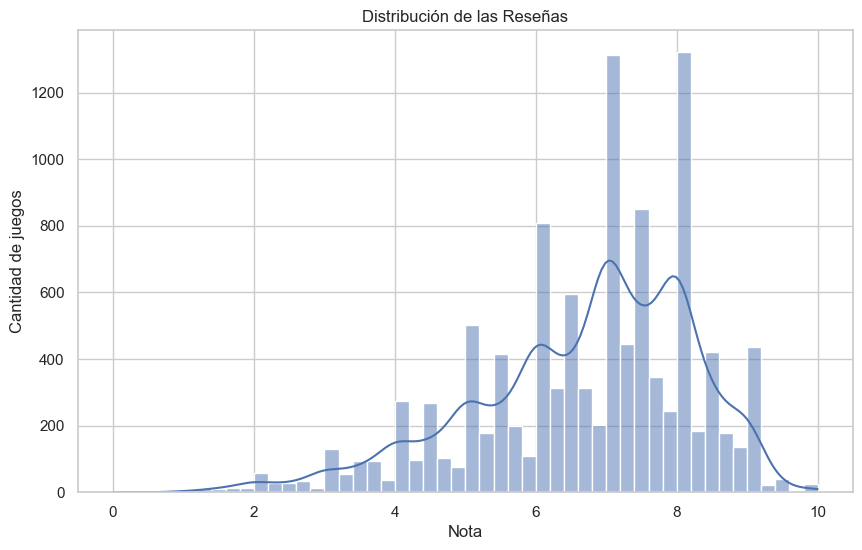

In [141]:
sns.set_theme(style="whitegrid")


plt.figure(figsize=(10, 6))
sns.histplot(df_limpio['score'], kde=True, bins=50)  

plt.title('Distribución de las Reseñas')
plt.xlabel('Nota')
plt.ylabel('Cantidad de juegos')
plt.show()

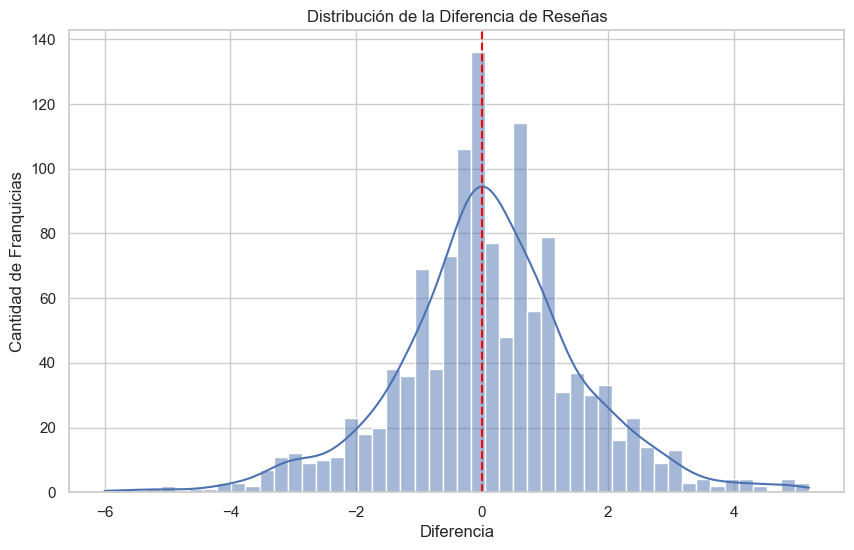

In [142]:
sns.set_theme(style="whitegrid")


plt.figure(figsize=(10, 6))
sns.histplot(df_diferencia['diferencia'], kde=True, bins=50)  


plt.axvline(x=0, color='red', linestyle='--')

plt.title('Distribución de la Diferencia de Reseñas')
plt.xlabel('Diferencia')
plt.ylabel('Cantidad de Franquicias')
plt.show()

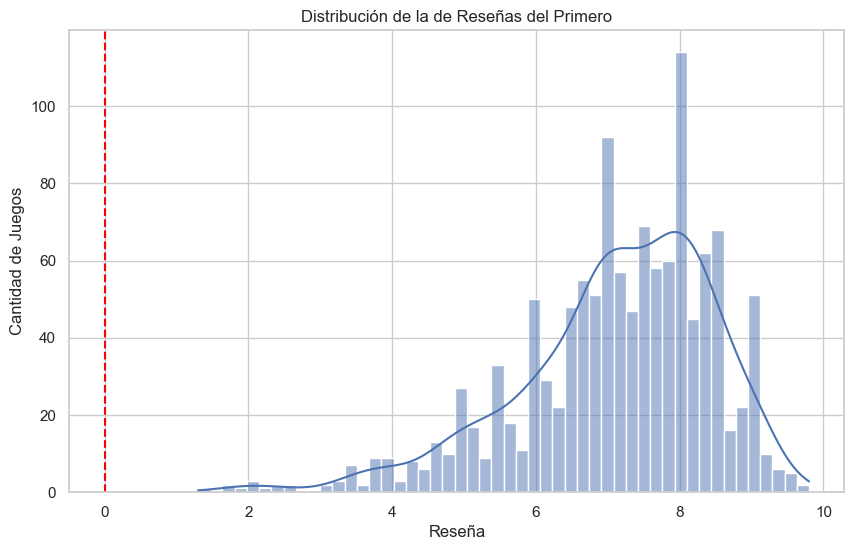

In [143]:
sns.set_theme(style="whitegrid")


plt.figure(figsize=(10, 6))
sns.histplot(df_diferencia['score_1'], kde=True, bins=50)  


plt.axvline(x=0, color='red', linestyle='--')

plt.title('Distribución de la de Reseñas del Primero')
plt.xlabel('Reseña')
plt.ylabel('Cantidad de Juegos')
plt.show()

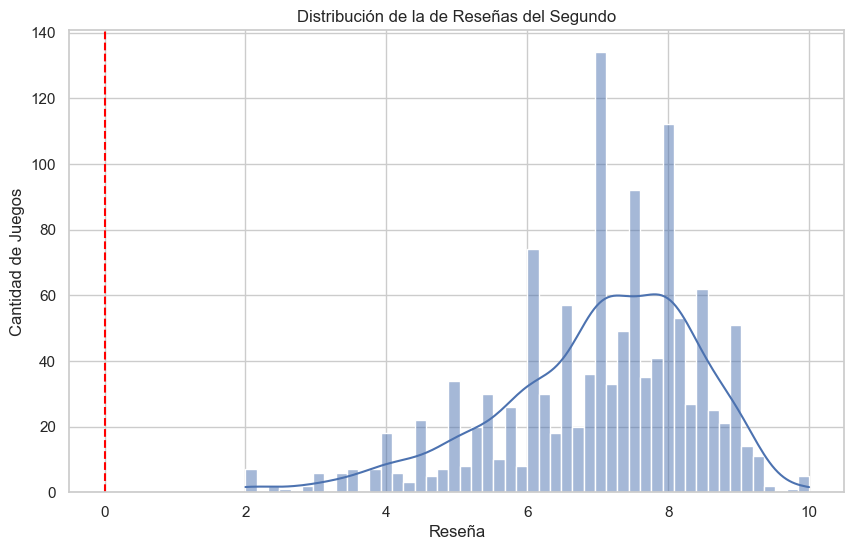

In [144]:
sns.set_theme(style="whitegrid")


plt.figure(figsize=(10, 6))
sns.histplot(df_diferencia['score_2'], kde=True, bins=50)  


plt.axvline(x=0, color='red', linestyle='--')

plt.title('Distribución de la de Reseñas del Segundo')
plt.xlabel('Reseña')
plt.ylabel('Cantidad de Juegos')
plt.show()

In [145]:
df_diferencia['diferencia'].describe()

count     1238.0
unique     417.0
top          0.0
freq        82.0
Name: diferencia, dtype: float64

# POR HACER
***

En este proceso quedan varias cosas pendientes, se queda atras con las exploraciones de las otras bases de datos, pero tiene otros aspectos donde puede dar una nueva perspectiva.

Para la proxima entrega de esta exploracion queda pendiente:

-El igualar la profundidad del EDA
-Notamos que en la base de datos hay más de una reseña por juego así que se podría elegir el sesgo, que puede ser quedarse con la nota mas nueva por que la opinion del juego cambio y envejeció mal o quedarse con la primera dado que fue la primera impresion, ya que estan los casos como cyberpunk 2077 que empezo mal pero impresión nota ha mejorado